#Identity verification without sharing too much

###Introduction

Each person has some associated values associated with them (from their home address, exercise levels, their date of birth, last 1000 search queries, income, education level, criminal convictions, genome, etc. A verifier (e.g. a bank) wants to confirm someone is who they say they are. The bank knows some of this information (or maybe knows summaries of this information), e.g. your height and weight. The bank asks for a summary of some of this information from you (or your device). For instance, the sum of (normalised) age, income and distance from London. Some values of the summary will be more or less likely given the information the bank already knows. Some noise will also be added to the summary value.

However, someone might be eavesdropping and want to infer your income. The noisy summary, given other information they know about the distribution of the population, will give the eavesdropper information about the values of the features.

Are there sets of feature values, known-values and summaries which allow the bank to gain evidence of a person's identity more quickly than an eavesdropper can gain knowledge about particular features of the user?

###Detailed Introduction

Every individual has a (potentially incomplete, potentially of any length) vector of features: $x_i$.

We need a function to generate arbitrary summaries of these features. A linear combination seems the most obvious, but we also want to ensure that information about individual features (and what about small groups of features?) is not revealed.

Neil suggested that the sum of a subset of features would work - I think we also need to normalise the features to make that work (e.g. age+income might not make sense by default). Maybe I'm thinking too literally...

Anyway. We have some function $f(x_i,w_t)$ which generates a summary from these features. The matrix $w_t$ tells the function which features to use. Presumably we could add noise (i.e. differential privacy like ideas).

We, as the verifier, also hold some of $x_i$ ourselves.

The aim is to:
   1. Determine if the prover is the person, $i$.
   2. Avoid the prover releasing any data about themselves (e.g. the summary can't provide a method for revealing, e.g. income, etc).

We must assume that:
   1. There are correlations in the values of $\mathbf{x}$.
    
###A simple example

A person has four features:
- age: 35
- income (in £k/year): 25
- distance from London (in 10s of km): 20
- weight in stone: 9

(ok, slightly ludicrious example! but trying to avoid the normalisation debate for now. Ignore all issues around e.g. how to include children, non-earners, etc, and non-normal...etc).

To illustrate, consider data about 1000 people, for these four features:

270504.0


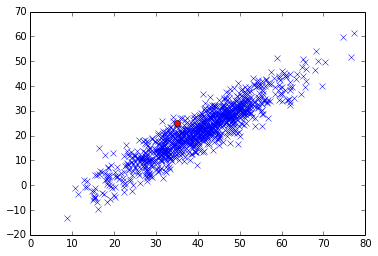

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#UK average age: 39.9, average income: 21.3, avg distance 20, weight:11.9
mu = np.array([39.9,21.3,20,11.9])
cov = np.diag([11**2,11**2,10**2,3**2]);
cov[0,1] = cov[1,0] = 10.5**2
cov[0,2] = cov[2,0] = -6**2
cov[1,2] = cov[2,1] = -2.8**2
cov[0,3] = cov[3,0] = 3.45**2
cov[1,3] = cov[3,1] = 4.5**2
cov[2,3] = cov[3,2] = 0

print (np.linalg.det(cov))
x = np.random.multivariate_normal(mu,cov,1000)
x[0,:] = np.array([35,25,20,9])

#plt.plot(x[:,2],x[:,1],'x')
#plt.plot(x[0,2],x[0,1],'ro')

plt.plot(x[:,0],x[:,1],'x')
plt.plot(x[0,0],x[0,1],'ro')

We ask the prover $i=0$ for a summary with $w_t = \left( 1,0,1,0 \right)^\top$. We'll assume that $f_i$ is the sum of these features.

Notice that we add some gaussian uncertainty to this summary.

In [2]:
w = np.array([1,0,1,0])
f = np.dot(x[0,:],w)+np.random.randn()*4.; #added some randomness (to do: determine correct value for this)
print f

53.9336554387


How likely is this? We know some of the features of this user, e.g. $k_i = [1,1,0,1]^\top$. We can create a new distribution, with the summary as one of the dimensions:

($x_2, x_4, f$)

If the previous covariance matrix was:

$\Sigma =\left( \begin{array}{cccc}
\Sigma_{11} & \Sigma_{12} & \Sigma_{13} & \Sigma_{14} \\
\Sigma_{21} & \Sigma_{22} & \Sigma_{23} & \Sigma_{24} \\
\Sigma_{31} & \Sigma_{32} & \Sigma_{33} & \Sigma_{34} \\
\Sigma_{41} & \Sigma_{42} & \Sigma_{43} & \Sigma_{44} \\
\end{array} \right) $

It is now:

$\Sigma =\left( \begin{array}{cccc}
\Sigma_{ff} & \Sigma_{f2} & \Sigma_{f4} \\
\Sigma_{2f} & \Sigma_{22} & \Sigma_{24} \\
\Sigma_{4f} & \Sigma_{42} & \Sigma_{44} \\
\end{array} \right) $

Where: $\Sigma_{fi} = \sum_{j \in F} \Sigma_{ij}$

(F is the set of features included, i.e. the non-zeros in $w_t$).

$\mu_{f} = \sum_{j \in F} \mu_{j}$

\rule

<blockquote>
**Side note on covariances** Ignoring the means for now, assume three random variables: 

$X_i, X_j, X_k$. We assume our summary is the sum of two parameters $X_i + X_j$. 

The covariance between this summary and the third parameter is 

$<(X_i + X_j) X_k> = <(X_i X_k) + (X_j X_k)> = <X_i X_k> + <X_j X_k> = \Sigma_{ij} + \Sigma_{jk}$
</blockquote>
Back to the problem.

We can test the likelihood of the summary by looking at the pdf.


In [3]:
import math

#Log Probability density function for a multivariate normal (mean, mu; covariance, cov) at point xs
def log_multv_normal(mu,cov,xs):
        logp = np.log(math.pow(np.linalg.det(cov),-.5));        
        logp += np.log(math.pow(2*np.pi,-len(mu)/2));
        inv = np.linalg.inv(cov)
        logps = np.zeros([xs.shape[0],1])
        for i,x in enumerate(xs):
            logps[i] = logp + (-.5 * np.dot(np.dot((x-mu),inv),(x-mu).T));
      #  logp += -.5 * np.dot(np.dot((x-mu*x.shape[1]).T,inv),(x-mu*x.shape[1]));

        return logps

In [4]:
''' 
#an improved version of this function is included later in this document

Determines pdf of x being sampled from distribution. 
w is a binary vector of elements included in summary.
f is the actual value of the summary (potentially including noise?)
mu and cov is the covariance of the distribution.

returns l = log likelihood of [f,x]
newmu and newcov = distribution, p(f,x) but where x is just the non-zero elements of w:
  f
  1
  3
  : the elements included by w
t = f and the excluded parameters of x, for some reason...
'''
def popsample(mu,cov,w,f,x):
    exc = np.nonzero(w==0)[0]; #list of row indices included and excluded from summary
    inc = np.nonzero(w==1)[0]; 
    newcov = np.zeros([1+len(exc),1+len(exc)])
    newcov[0,0] = cov[np.ix_(inc,inc)].sum()
    for i,idx in enumerate(exc):
        newcov[i+1][0] = cov[idx,w==1].sum()
        newcov[0][i+1] = cov[idx,w==1].sum()
    newcov[np.ix_(range(1,1+len(exc)),range(1,1+len(exc)))] = cov[np.ix_(np.nonzero(w==0)[0],np.nonzero(w==0)[0])]
    
    newmu = np.zeros(1+len(exc))
    newmu[0] = mu[inc].sum()
    newmu[1:] = mu[exc]
    
    #TODO assumes we know all of the excluded parameters - we need to marginalise if we don't.
    
    t = np.hstack([f,x[exc]])
    t = np.array([t]).T  #get it into the right shape
    l = log_multv_normal(newmu,newcov,t.T)
    return l,newmu,newcov,t

l,newmu,newcov,t = popsample(mu,cov,w,f,x[0,:])

In [5]:
import scipy.stats
inv = np.linalg.inv(newcov)
r = np.dot(np.dot((t.T-newmu),inv),(t.T-newmu).T)
print "CDF outside Mahalanobis radius %0.3f of centre: %0.3f" % (r,1-scipy.stats.chi2.cdf(r, len(newmu)))

CDF outside Mahalanobis radius 5.275 of centre: 0.153


In [6]:
#alternative less likely example
x[0,:] = [18,29,10,11.9]
f = np.dot(x[0,:],w)+np.random.randn()*4.;
l,newmu,newcov,t = popsample(mu,cov,w,f,x[0,:])
inv = np.linalg.inv(newcov)
r = np.dot(np.dot((t.T-newmu),inv),(t.T-newmu).T)
print "CDF outside Mahalanobis radius %0.3f of centre: %0.3f" % (r,1-scipy.stats.chi2.cdf(r, len(newmu)))

CDF outside Mahalanobis radius 26.781 of centre: 0.000


So the original value of x is far more likely than the other value of x. We've not been given all the details about the user, but we've still been able to infer from the summary whether their features are likely or not, given the prior probability distribution.

What does the feature vector mean for an eavesdropper's estimates of a user's feature?

###Reminder: Conditional probability distribution of a multivariate gaussian

Given $\mathbf{x}$ made up of two vectors $\mathbf{x_i}$ & $\mathbf{x_j}$ is Normally Distributed, with mean $\mathbf{\mu}$ and covariance $\Sigma$. Where both parameters are made up of components associated with the two vectors.

$\mathbf{\mu} =\left( \begin{array}{c}
\mu_{i} \\
\mu_{j} \\
\end{array} \right) $

$\Sigma =\left( \begin{array}{cc}
\Sigma_{ii} & \Sigma_{ij} \\
\Sigma_{ji} & \Sigma_{jj} \\
\end{array} \right) $

The conditional distribution of $\mathbf{x_i}$ given $\mathbf{x_j}$ is normal, with mean and variance:

$\mathbf{\mu_{i|j}} = \mathbf{\mu_i} + \Sigma_{ij} \Sigma_{jj}^{-1} \left(\mathbf{x_j}-\mathbf{\mu_j} \right)$

$\Sigma_{i|j} = \Sigma_{ii} - \Sigma_{ij} \Sigma_{jj}^{-1} \Sigma_{ij}^\top$

Summary: If we know the value of some component $a$ of a Normal probability distribution $p(a,b)$ we can calculate a new distribution $p(b|a)$, which is also normal. In our case the variable being conditioned upon (a), is the sum of some of the variables or features (that make up our summary value).

###The probability density of $f=\sum_i X_i$

We want to understand how much knowledge we gain about a given feature $x_i$.

We know from above that, given the features ($x_1...$) included in the summary random variable $F$, the mean and variance is:

$\mu_{f} = \sum_{j \in F} \mu_{j}$

$\Sigma_{fi} = \sum_{j \in F} \Sigma_{ij}$

$\Sigma_{ff} = \sum_{i \in F} \sum_{j \in F} \Sigma_{ij}$

We are interested in what our new estimates are for $X_i$.

$\mathbf{\mu_{i|f}} = \mathbf{\mu_i} + \Sigma_{if} \Sigma_{ff}^{-1} \left( f_v-\mu_f \right)$

$\Sigma_{i|f} = \Sigma_{ii} - \Sigma_{if} \Sigma_{ff}^{-1} \Sigma_{if}^\top$

Example:

Let these two values represent something about people that are positively correlated (e.g. Height and Weight):

$\mathbf{\mu} =\left( \begin{array}{c}
1 \\
2 \\
\end{array} \right) $


$\Sigma =\left( \begin{array}{cc}
3 & 2 \\
2 & 4 \\
\end{array} \right) $


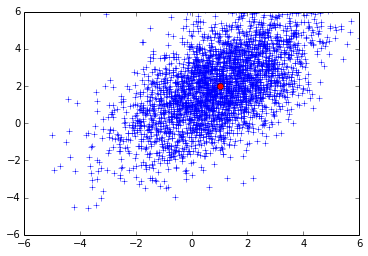

In [7]:
D = 2;
mu = np.array([1,2]);
cov = np.array([[3,2],[2,4]]);
x = np.random.multivariate_normal(mu,cov,3000);
plt.plot(x[:,0],x[:,1],'+')
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.plot([1],[2],'or')
plt.figure()

We are told that the feature parameter $f=5$ so this means we know that $X_1 + X_2 = 5$. What do we now know about $X_1$ and $X_2$?

Before, the marginal on $X_1$ had: $\mu_1 = 1$ $\sigma_1 = 3$.

Substituting into the earlier equations:

$\mu_{f} = 1 + 2 = 3$

$\Sigma_{f1} = 3+2 = 5$

$\Sigma_{f2} = 2+4 = 6$

$\Sigma_{ff} = 3+2+2+4 = 11$

$\mathbf{\mu_{1|f}} = 1 + 5 \times 11^{-1} \times \left( 5 - 3 \right) = 1.91$

$\Sigma_{1|f} = 3 - 5 \times 11^{-1} \times 5 = 3 - 2.27 = 0.72$

$\mathbf{\mu_{2|f}} = 2 + 6 \times 11^{-1} \times \left( 5 - 3 \right) = 3.09$

$\Sigma_{2|f} = 4 - 6 \times 11^{-1} \times 6 = 4 - 3.27 = 0.72$



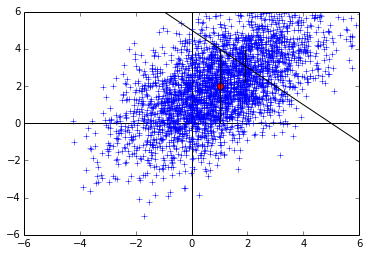

In [8]:
D = 2;
mu = np.array([1,2]);
cov = np.array([[3,2],[2,4]]);
x = np.random.multivariate_normal(mu,cov,3000);
plt.plot(x[:,0],x[:,1],'+')
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.plot([1],[2],'or')
plt.plot([10,-5],[-5,10],'k-')
plt.vlines(0,-6,6)
plt.hlines(0,-6,6)
plt.plot([1.91,1.91],[3.09-np.sqrt(0.72),3.09+np.sqrt(0.72)],'k-')
plt.plot([1,1],[2-np.sqrt(4),2+np.sqrt(4)],'k-')

The two vertical lines indicate the spread of likely $x_2$ values before (with red dot) and after the summary is revealed, given the correlation structure.

This shows how much more information the eavesdropper has about the user.

To add random noise to the summary value $f$ we can modify the covariances. One might assume the addition of an uncorrelated multivariate gaussian would be reasonable, however the LaPlace distribution is often preferred:

<blockquote>
Alternately, using Gaussian noise with variance calibrated to $\Delta f \; ln(1/\delta)/\varepsilon$,
one can achieve $(\varepsilon, \delta)$-differential privacy. Use of the Laplace
mechanism is cleaner and the two mechanisms behave similarly under composition.
</blockquote>
--Dwork and Roth.

<blockquote>
An alternative to adding Laplacian noise is to add Gaussian noise. In
this case, rather than scaling the noise to the l 1 sensitivity ∆f , we
instead scale to the l 2 sensitivity:
</blockquote>
--Dwork and Roth, see below.

But this is mainly for the convenience of the algorithm. So we add multivariate uncorrelated, random gaussian noise (covariance s, is diagonal $\mathbf{\sigma}$):

$\mu_{f} = \sum_{j \in F} \mu_{j}$

$\Sigma_{fi} = \sum_{j \in F} \Sigma_{ij}$

$\Sigma_{ff} = \sum_{i \in F} \sum_{j \in F} \Sigma_{ij} + s_{ij}^2$

$s_{ij}=\sigma_i$ if $i=j$

$s_{ij}=0$ otherwise

so can just add $\sum_i \sigma_i^2$ to $\Sigma_{ff}$:

$\Sigma_{ff} = \sum_{i \in F} \sum_{j \in F} \Sigma_{ij} + \sum_i \sigma_i^2$

Note: Adding uncertainty in one direction doesn't help any more than another. Not a surprise as we just get a single, summed value. What would help would be to **scale some values** (as this will drag them more into the noise generated by this extra term).

Now a detour into Differential Privacy...

##Differential Privacy

*From The Algorithmic Foundations of Differential Privacy by Dwork and Roth*

General definition (ideal): A promise by a curator to a data subject that they will not be affected by being included in a database, regardless of what other sources are available. An analyst will learn nothing about an individual while learning something about the population.

*Key phrase*: Linkage attack - using data from a second, auxilary data source to infer additional information from our 'anonymised' database.

###Features of differential privacy and privacy in general

- Data **cannot be fully anonymised** and remain useful.
- Identification of 'anonymised' records is not the only risk.
- Queries over large sets are not protective (e.g. cases in set minus cases in set/bob)
- Query auditing is problematic (e.g. trying to ensure anonymity per query - computationally intractable, and might reveal something by not disclosing!)
- Summary statistics are not safe
- 'ordinary facts' (e.g. an individual's bread-buying) are not 'safe' (e.g. give a clue re diabetes).
- 'Just a few' people affected argument fraught with issues (often outliers need most protection). Also could apply logic to just release the complete data of 1% of rows.

###The Model of Computation

*Key phrase*: Non-interactive model (a database that will only have a fixed, known set of queries made against it). This gives best accuracy, for a given disclosure as it can correlate noise, knowing the structure of the queries. **Maybe useful for the privacy mechanism you're envisaging?**

*Side note*: Surveying illegal behaviour: The participant is asked to flip a coin. If tails they report truth. If heads, they flip the coin again. Report yes if heads, no if tails.

<img src="files/images/diff_priv_coin_small.png" />
![Flipping coins to randomise answers]('files/diff_priv_coin.png')

- "Any non-trivial privacy guarantee that holds, regardless of future sources of auxilar information requires **randomisation**".

####Distance between databases

Use the $l_1$ norm. $||x||_1 = \sum_{i=1}^{|\chi|} |x_i|$ where $x_i$ is the number of entries of type i.
So the distance between two databases is $||x-y||_1$.

###The Differential Privacy Rule

A randomisation algorithm $M$, is $(\varepsilon, \delta)$-differentially private if $\forall S \subseteq Range(M)$ and for all $x,y \in N^{|\chi|}$ such that $||x-y|| \leq 1$:

$P[M(x) \in S] \leq e^\varepsilon P[M(y) \in S] + \delta$

####In simipler terms

If we have a database $x$ that has been modified by at most one item, to become database $y$. The probability of the output of the randomisation function we have applied to $x$ will be similar to $y$, with a bound of:

$P_x \leq e^\varepsilon P_y + \delta$

which means that the two probabilities $P_x$ and $P_y$ must be similar.

If $\delta \neq 0$ there might be some database $y$ for which $M(y)$ is far more likely than $M(x)$.

###Privacy Loss

Given the output of the randomisation function is $\xi$, the privacy loss is defined as the log-likelihood ratio of the two databases:

$L^{(\xi)}_{M(x)||M(y)} = ln {{P[M(x)=\xi]} \over {P[M(y)=\xi]}}$

###Summary:

The $(\varepsilon, \delta)$ - differential privacy rule is:

$P[M(x) \in S] \leq e^\varepsilon P[M(y) \in S] + \delta$

which implies that:

**for all adjacent x,y, the absolute value of $L$ will be bounded by $\varepsilon$ with probability of at least $1-\delta$**.

###Extension to multiple queries and group privacy

We are interested in the bounds on $L$ if we ask several queries, and the bounds on $L$ for several rows.

####Separate queries

Worst case, if $k$ queries are made, then:

$\varepsilon' = k \varepsilon$

$\delta' = k \delta$

####Group privacy

(particularly relevant)

Worst case, if $k$ rows are included, then:

$\varepsilon' = k \varepsilon$

$\delta' = k e^{(k-1)\varepsilon} \delta$

###Individual utility

An individual's utility will not be harmed by more than a factor of $e^\varepsilon \approx 1 + \varepsilon$

##The LaPlace Mechanism

If two databases $x$ and $y$ are the same except for one user, the $l_1$ sensitvity describes how much (the maximum) the summary value $f$ differs between these two databases:

$l_1$ sensitivity $\Delta f = max_{x,y \in N^{|\chi|}} || f(x) - f(y) ||_1$

<blockquote>
The $l_1$ sensitivity of a function f captures the magnitude by which
a single individual’s data can change the function f in the worst case,
and therefore, intuitively, the uncertainty in the response that we must
introduce in order to hide the participation of a single individual.
</blockquote>

<blockquote>
The Laplace mechanism preserves $(\varepsilon, 0)$-differential privacy.
</blockquote>


##Learning Identity

When a user provides a summary value $f$, we want to:

1. Increase our certainty in our belief about their identity
2. Minimise the increase in the knowledge an evesdropper might have about a feature of the user.

These two elements can be described by the change in entropy:

1. We know a subset of paramters $\mathbf{x}_k$ of the total $\mathbf{x}$. We want to know the change in entropy between $p(x|x_k)$ and $p(x|x_k, f)$.

2. The evesdropper wants to estimate a feature $p(x_i)$. The change in entropy for a given feature $i$, between $p(x_i)$ and $p(x_i|f)$. We're interested in the worst-case, i.e. $max_i \left[ H(p(x_i|f))-H(p(x_i)) \right]$

####Revision
- The entropy of a normal distribution is ${}^1/_2 ln \left[ (2 \pi e)^n |\Sigma| \right]$.
- The entropy of any probability distribution is $H[p(x)] = \int -p(x) ln p(x) dx$
- The mutual information between two distributions is: $I[X;Y] = H(Y) - H(Y|X)$
- Which can also be written as: $I[X;Y] = D_{KL}\left(p(x,y) || p(x)p(y) \right)$
- Entropy is effectively a measure of 'uncertainty', the mutual information is effectively how much less uncertain we are about Y, now we know X.
- The normal distribution has maximal entropy for the given $\Sigma$.

First, a function to calculate the entropy of a multivariate gaussian:

In [9]:
import numpy as np
#to find the entropy of a guassian with covariance sigma
def entropy(sigma):
    d = np.linalg.det(sigma)
    n = max(sigma.shape)
    return 0.5 * np.log(((2*np.pi*np.e)**n)*d)
#H([2,0;0,2])-H([2,0;0,1])
print entropy(np.array([[2,0],[0,2]]))-entropy(np.array([[2,0],[0,1]]))

0.34657359028


Next, two functions to find the mutual information for 1. and 2.:

In [1]:
''' 
Determines mean and covariance of p(f,x)
w is a binary vector of elements included in summary.
mu and cov is the covariance of the distribution.
returns mean and covariance of p(f,x)
Note that f is the first element in mu
The remaining elements are x.

sigma is the variance in the noise added.'''

def addF(mu,cov,w,sigma=None):
    exc = np.nonzero(w==0)[0]; #list of row indices included and excluded from summary
    inc = np.nonzero(w==1)[0]; 
    newcov = np.zeros([1+len(mu),1+len(mu)])
    if (sigma==None):
        noiseVariance = 0;
    else:
        noiseVariance = sigma*sum(inc) #sigma is added to each dimension included.
    newcov[0,0] = cov[np.ix_(inc,inc)].sum()+noiseVariance
    for i in range(len(mu)):
        newcov[i+1][0] = cov[i,w==1].sum()
        newcov[0][i+1] = cov[i,w==1].sum()
    newcov[np.ix_(range(1,1+len(mu)),range(1,1+len(mu)))] = cov
    
    newmu = np.zeros(1+len(mu))
    newmu[0] = mu[inc].sum()
    newmu[1:] = mu
    #TODO assumes we know all of the excluded parameters - we need to marginalise if we don't.????
    return newmu,newcov

Next: condition on part of the parameters: I.e. find $p(\mathbf{x_i}|\mathbf{x_j})$ where $\mathbf{x_i}$ and $\mathbf{x_j}$ are parts on the whole vector $\mathbf{x}$.

$\mathbf{\mu_{i|j}} = \mathbf{\mu_i} + \Sigma_{ij} \Sigma_{jj}^{-1} \left( j_v-\mu_j \right)$

$\Sigma_{i|j} = \Sigma_{ii} - \Sigma_{ij} \Sigma_{jj}^{-1} \Sigma_{ij}^\top$


In [11]:
'''
Finds the mean and covariance of a multivariate distribution
with mean mu and covariance cov, given the values in known.
The values in known are indexed by binary vector w.

If the length of known is n, and the length of mu is m, then
the resulting distribution will have m-n dimensions.'''
def dist_conditional(cov,w,mu=None,known=None):
    exc = w==0;#np.nonzero(w==0)[0]; #list of row indices included and excluded from condition
    inc = w==1; #np.nonzero(w==1)[0]; #inc = j, exc = i.
    cov_ii = cov[np.ix_(exc,exc)]
    cov_ij = cov[np.ix_(exc,inc)]
    inv_cov_jj = np.linalg.inv(cov[np.ix_(inc,inc)])    
    newcov = cov_ii - np.dot(np.dot(cov_ij,inv_cov_jj),cov_ij.T)
    if (known!=None):
        mu_i = mu[np.ix_(exc)]
        mu_j = mu[np.ix_(inc)]
        newmu = mu_i + np.dot(np.dot(cov_ij,inv_cov_jj),(known-mu_j))
        return newmu,newcov
    else:
        newmu = None
        return newcov

In [12]:
w = np.array([1,1,0,0])
mu_X = np.array([0,0,0,0])
cov_X = np.array([[4,1,0,0],[1,4,1,0],[0,1,4,1],[0,0,1,4]])
known = np.array([1,0,0,0])

#find p(f,x)
mu_XF, cov_XF = addF(mu_X,cov_X,w,1)

#print "XF"
#print cov_XF
#remove all but x_i
#find p(f, x_i)
print "What does the eavesdropper gain about each feature?"
for i in range(4):
    mu_XiF = mu_XF[np.ix_([0,i+1])]
    cov_XiF = cov_XF[np.ix_([0,i+1],[0,i+1])]
    mu_Xi = mu_XiF[1]
    cov_Xi = cov_XiF[np.ix_([1],[1])]
    fsel = np.zeros_like(mu_XiF);
    fsel[0]=1;

    #find p(x_i|f)
    cov_XigF = dist_conditional(cov_XiF,fsel)

    print "for i=%d:" % i
    print "I[p(x_i);p(x_i|f)]"
    print entropy(cov_Xi)-entropy(cov_XigF)

print "What does the eavesdropper gain about the whole feature set?"
###############
fsel = np.zeros_like(mu_XF);
fsel[0]=1;
#find p(x|f)
cov_XgF = dist_conditional(cov_XF,fsel)
print "I[p(x);p(x|f)]"
print entropy(cov_X)-entropy(cov_XgF)
###############
#find p(f,x)
mu_XF, cov_XF = addF(mu_X,cov_X,w,1)

#print "XF"
#print cov_XF
#find p(f,x|k)
known_shifted = np.hstack([0,known])
#print "A1"
#print known_shifted
cov_XFgK = dist_conditional(cov_XF,known_shifted)
#print "XF|K"
#print cov_XFgK

#we want p(x|k), so need to delete f
#mu_XgK = mu_XFgK[1:]
cov_XgK = cov_XFgK[1:,1:]

#find p(x|f,k)
known_with_f = np.hstack([1,known])
#print "A2"
#print known_with_f
cov_XgFK1 = dist_conditional(cov_XF,known_with_f)
f_selector = np.zeros(cov_XFgK.shape[0])
f_selector[0]=1
#print "A3"
#print f_selector
cov_XgFK2 = dist_conditional(cov_XFgK,f_selector)

#print "cov_XgFK1"
#print cov_XgFK1
#print "cov_XgFK2"
#print cov_XgFK2
print "What does the bank gain about the total feature set?"
print "I[p(x|x_k);p(x|x_k,f)]"
print entropy(cov_XgK)-entropy(cov_XgFK1)

What does the eavesdropper gain about each feature?
for i=0:
I[p(x_i);p(x_i|f)]
0.419875327376
for i=1:
I[p(x_i);p(x_i|f)]
0.419875327376
for i=2:
I[p(x_i);p(x_i|f)]
0.0114947591123
for i=3:
I[p(x_i);p(x_i|f)]
0.0
What does the eavesdropper gain about the whole feature set?
I[p(x);p(x|f)]
1.1989476364
What does the bank gain about the total feature set?
I[p(x|x_k);p(x|x_k,f)]
0.779072309023


So what does this mean?

- The first item says that the eavesdropper gains up to 0.42nats about individual features.
- Note that the information gain about feature i=3 is zero. This makes sense as the covariance between the two features that make up the summary (0 and 1) and feature i=3 is zero.
- Next what does the eavesdropper gain about the whole feature set? 1.20nats. Question: Does it make sense this adds up to more than the sum of information about individual features, or have I made a mistake? Yes it does make sense, see below.
- Finally, what does the bank gain? As one of the features that makes up the summary is known to the bank, it learns less than the eavesdropper about the whole feature set. This can be avoided by asking for a feature set that doesn't include what we know already. This doesn't really help though, as the bank is probably interested in reaching some sort of threshold. Does the bank learn more if x_k and f seem to be incompatible, given the known x_k?...?

###Aims of the two parties

The aims of the eavesdropper and the bank are different however anyway, so although it seems the bank is doing worse, the bank is interested in the information gain over the whole of $\mathbf{x}$, while the eavesdropper is (presumably) interested in inferring a particular value $x_i$.

###Why is the information the evesdropper gains about the whole distribution more than it gains for individual features?

For a simplified example, imagine two binary features A and B. They are dependent:


    Joint Distribution
         A=0 A=1
    B=0  0.5   0
    B=1  0   0.5
    
However, before the evesdropper observes something, they don't know this, and they have the following prior distribution:

    Joint Distribution (a priori)
         A=0  A=1
    B=0  0.25 0.25
    B=1  0.25 0.25
    
The marginal probabilities of the two features have not changed, i.e. P(A) = [0.5,0.5], P(B) = [0.5, 0.5]. So we can see that the mutual information between what was known before and after about the two features, individually, has not changed: $MI = H(A) - H(A|) = -(0.5 \times -1 + 0.5 \times -1) - -(0.5 \times -1 + 0.5 \times -1) = 0$

Compare this with the MI over the whole distribution:

$H(A,B) = {}^1/_4 \times -2 + {}^1/_4 \times -2 + {}^1/_4 \times -2 + {}^1/_4 \times -2 = 2$

$H(A,B|) = {}^1/_2 \times -1 + {}^1/_2 \times -1 = 1$

$MI = 2-1 = 1$

So we've gained 1 bit of data about the whole distribution, but have gained no information about the individual marginal probability distributions.

###General case

Next: the general case
- We want to know what the difference or ratio in the most the eavesdropper can glean vs what the bank can learn, given certain correlation structures and choices of summary statistic.

I tried to make a start, but ended up with complicated expressions...

A general expression for the amount of information gain an evesdropper makes about a single parameter.

$I[p(x_i); p(x_i|f)] = [n_1/2 ln(2 \pi e) + .5 ln (\Sigma_{ii}-\Sigma_{ik} \Sigma_{kk}^{-1} \Sigma_{ik}^\top)] - [n_2/2 ln(2 \pi e) + .5 ln (\Sigma_{ii}-\Sigma_{ikf} \Sigma_{kfkf}^{-1} \Sigma_{ikf}^\top)]$

$n_1 = |x| - |x_k|$

$n_2 = |x| - |x_k|$

So the $n_1/2 ln(2 \pi e)$ bits cancel.

This leaves:

$I = {1 \over 2} ln \left( {{\Sigma_{ii}-\Sigma_{ik} \Sigma_{kk}^{-1} \Sigma_{ik}^\top} \over {\Sigma_{ii}-\Sigma_{ikf} \Sigma_{kfkf}^{-1} \Sigma_{ikf}^\top}} \right)$

There might be a big simplification we can do here, as the covariance between i and k, and i and {k,f} is only one row different. The adjoint and determinant calculations are quite recursive, and so it would seem likely there's a shortcut somewhere.

We need to compare the above to a similar expression for the bank.

Then we need to look at what combination of summary stats will maximise the information gain for the bank, while still minimising the (maximum across features) info gain for the evesdropper.

We also need to decide on a threshold.

##Differential Privacy Again

We also need to connect up the above considerations with the concepts from differential privacy. How much privacy has been lost (in terms of $\varepsilon$)?

Not sure how easy it is to link mutual info to diff. priv. As Diff Priv assumes uniform priors maybe??

See:

http://arxiv.org/abs/1402.3757

###Ideas

We need an expression to find the sensitivity in the correlated case, then we can use this to select the noise scale. We can also used LaPlace noise, if we can find an expression for its Entropy? (although we've assumed the data has gaussian noise). Then we can look at whether we gain enough info for a reasonable value of $\varepsilon$ to allow the bank to identify the person with confidence.

##Test code and other junk

In [13]:
#Test code to roughly check the conditional probability distribution behaviour is as expected

cov1 = np.array([[4,1,0,0],[1,4,1,0],[0,1,4,1],[0,0,1,4]])
w1 = np.array([1,0,0,0])
cov2 = dist_conditional(cov1,w1)

print cov1
print "X|x1"
print cov2

w2 = np.array([0,0,1])
cov3 = dist_conditional(cov2,w2)
print "(X|x1)|x2"
print cov3
print "----"
w3 = np.array([1,0,0,1])
cov4 = dist_conditional(cov1,w3)
print "X|(x1,x2)"
print cov4

[[4 1 0 0]
 [1 4 1 0]
 [0 1 4 1]
 [0 0 1 4]]
X|x1
[[ 3.75  1.    0.  ]
 [ 1.    4.    1.  ]
 [ 0.    1.    4.  ]]
(X|x1)|x2
[[ 3.75  1.  ]
 [ 1.    3.75]]
----
X|(x1,x2)
[[ 3.75  1.  ]
 [ 1.    3.75]]
